In [27]:
import numpy as np
import vip_hci
from os import mkdir
from os.path import join, sep,exists
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import stats
from scipy.ndimage.filters import median_filter
from scipy.ndimage.interpolation import shift

Perform H Band reduction

In [28]:
# Set up paths 
frameSize = 351
band = 'H'
tg_name= '2M1207'
useRefFrames = False
path_input = '/home/ubuntu/Downloads/2M1207_bands/Hband/'
path_output = path_input + 'out/'
sep='/'
print(path_input)

path_flats = path_input+'flats'+sep
path_flats_darks = path_input+'flats/darks'+sep
path_sci = path_input+'sci'+sep
path_darks = path_input+'darks'+sep

/home/ubuntu/Downloads/2M1207_bands/Hband/


In [29]:
# File list
filelist_flats = glob.glob(path_flats+'*.fits')
filelist_flats_darks = glob.glob(path_flats_darks+'*.fits')
filelist_sci = sorted(glob.glob(path_sci+'*.fits'))
filelist_darks = glob.glob(path_darks+'*.fits')

print((filelist_sci))

['/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_54_41.920.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_56_08.901.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_57_35.981.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_59_03.178.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_00_51.350.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_02_18.216.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_03_44.710.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_05_11.355.fits']


# H BAND RAW IMAGE

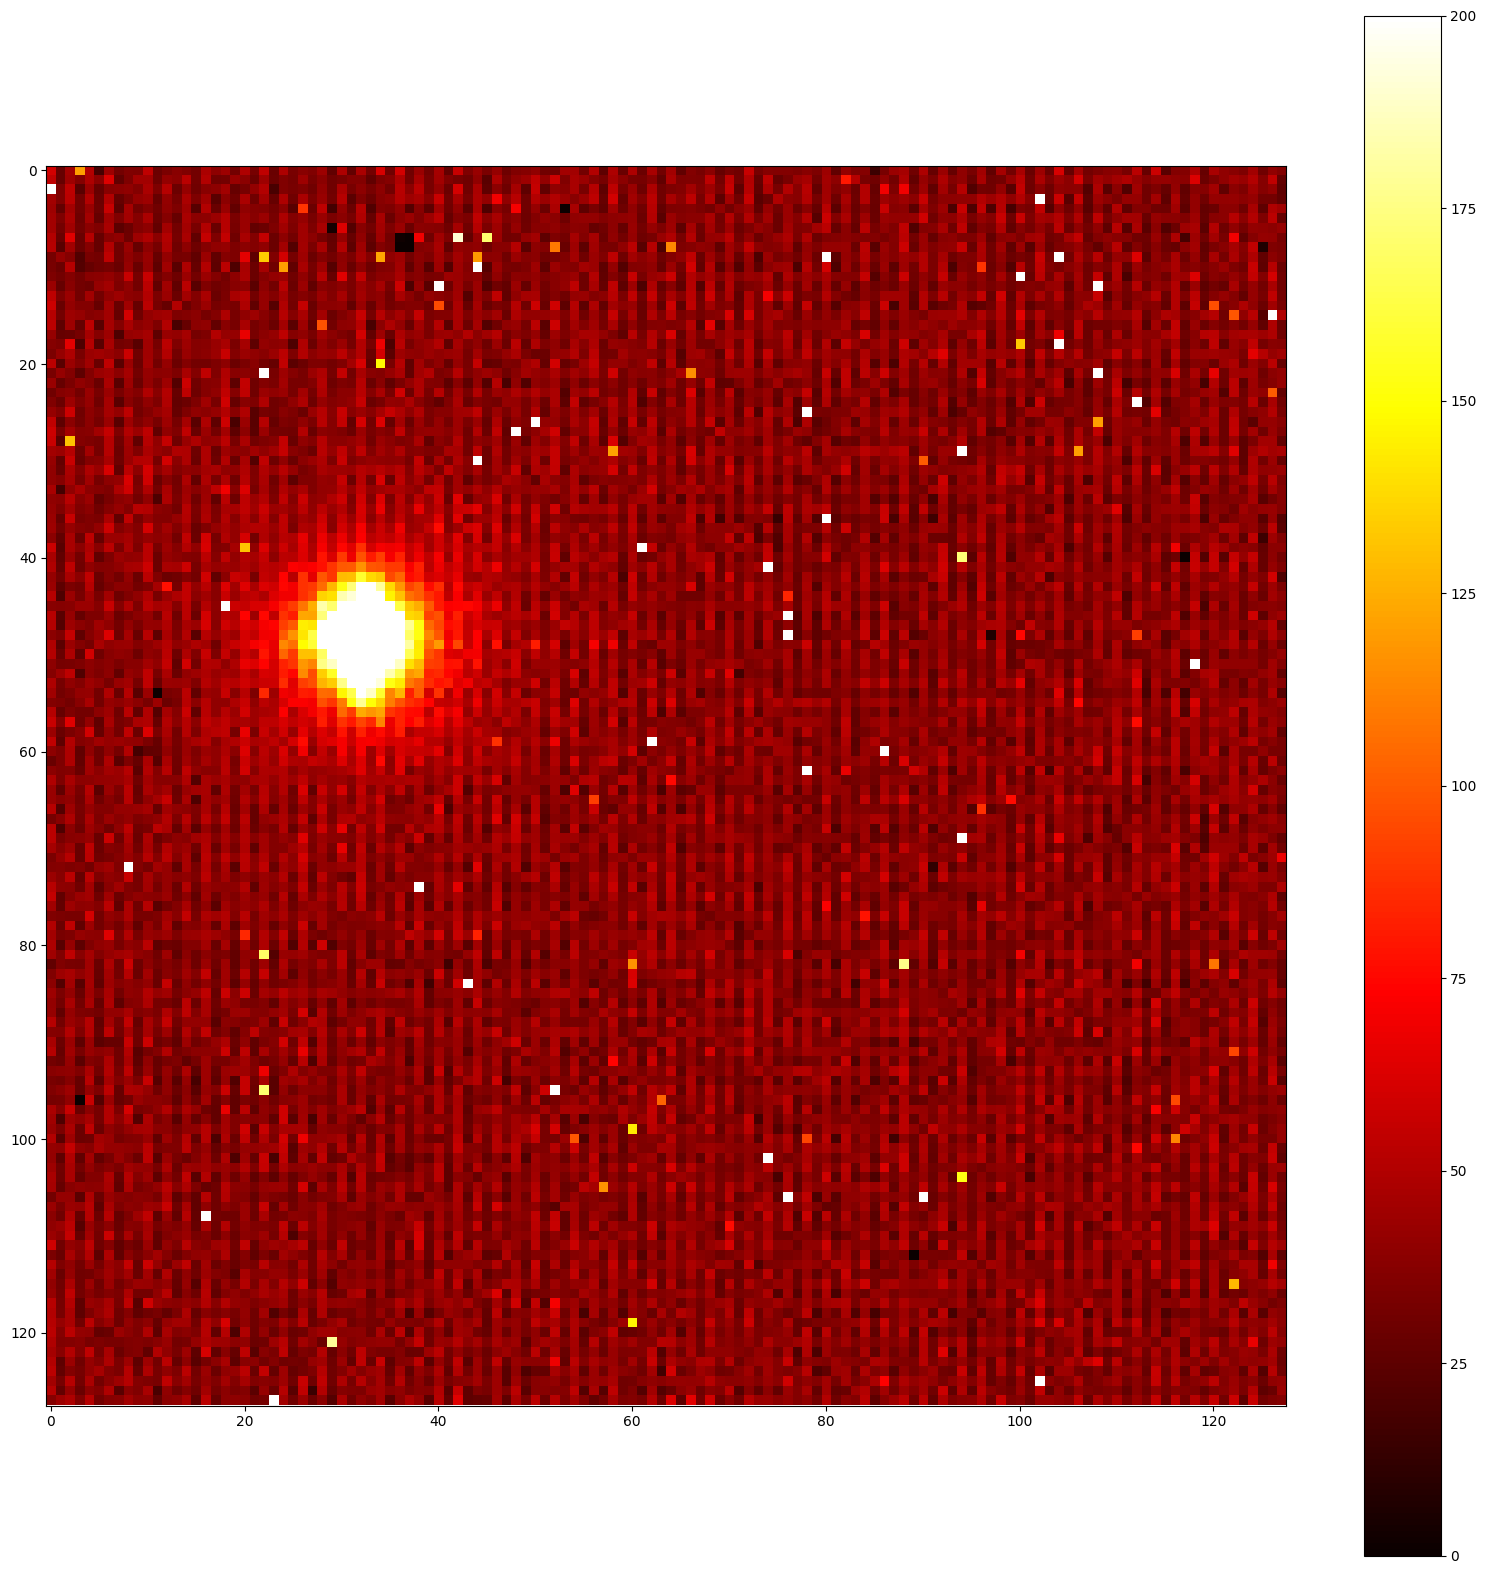

In [30]:
raw_sci = fits.open(filelist_sci[0])[0].data
crop = 128
dimx = raw_sci.shape[0]
dimy = raw_sci.shape[1]
x1 = int((dimx - crop)/2)
x2 = int(x1 + crop)
y1 = int((dimy - crop)/2)
y2 = int(y1 + crop)
raw_sci = shift(raw_sci,[-100,-100])
raw_cropped = raw_sci[x1:x2,y1:y2]
raw_cropped.shape
plt.figure(figsize=(20,20))
plt.imshow(raw_cropped,vmin=0,vmax=200,cmap='hot')
plt.colorbar()
plt.show();

The above pixel values are simply what were measured on the CCD when attempting to observe the exoplanet 2M1207, with no editing or corrections yet. 

We wrote a function to crop a given frame to crop the darks, flats, and biases as well as to make sure they are cropped the same way as the raw science frame.  

In [31]:
def crop(image, crop = 128):
    dimx, dimy = image.shape[0], image.shape[1]
    x1, y1 = int((dimx - crop)/2), int((dimy - crop)/2) 
    x2, y2 = int(x1 + crop), int(y1 + crop)
    image = shift(image, [-100,-100])
    return image[x1:x2,y1:y2]

# H BAND MASTER FLAT

The function get_frames retrieves all of the frames for a given band. The options are one of the following strings: "Hband", "Jband", "Kband", or "Lband" since those are the names of the directories for each wavelength band.

The function get_frames returns a dictionary. To access the flats simply use frames_dict['flats']

The function get_frames_dir is a helper function that reads every .fits file for each type of exposure: 'flats' , 'dark flats' which have a different exposure as reported above, 'sci' for science, and 'darks'. 

In [105]:
def get_frames(band, path_input = '/home/ubuntu/Downloads/2M1207_bands/',
             sep = '/'):
    frames_dict = {}
    path_input = path_input + band + sep
    frames_dict['flats'] = get_frames_from_dir(path_input+'flats'+sep)
    frames_dict['flat darks'] = get_frames_from_dir(path_input+'flats' + sep + 'darks'+sep)
    frames_dict['sci'] = get_frames_from_dir(path_input+'sci' + sep)
    frames_dict['darks'] = get_frames_from_dir(path_input+'darks' + sep)
    return frames_dict

def get_frames_from_dir(dir_path):
    frame_paths = glob.glob(dir_path + '*.fits')
    return [fits.open(frame_paths[file_num])[0].data
                for file_num in range(len(frame_paths))]

jband_dict, hband_dict = get_frames("Jband"), get_frames("Hband")
kband_dict, lband_dict = get_frames("Kband"), get_frames("Lband")
hband_dict['darks']

[array([[ 137.66667 ,  117.166664,  112.666664, ...,  136.16667 ,
          124.5     ,  218.33333 ],
        [  66.166664,   53.333332,   74.666664, ...,   37.833332,
           60.5     ,   44.333332],
        [  57.166668,   63.833332,  117.      , ...,   70.833336,
          145.5     ,   54.333332],
        ...,
        [  41.833332,    0.      ,   60.833332, ...,   27.      ,
           54.166668,   29.833334],
        [  55.166668,  -53.166668,   33.166668, ...,   23.833334,
           41.666668,   -0.5     ],
        [ -12.      , -166.5     ,  -20.166666, ...,  -60.166668,
          -18.833334,  378.66666 ]], dtype='>f4'),
 array([[ 137.33333  ,  115.833336 ,  113.5      , ...,  142.16667  ,
          121.833336 ,  217.83333  ],
        [  66.       ,   55.333332 ,   76.333336 , ...,   44.333332 ,
           58.       ,   46.       ],
        [  55.166668 ,   62.5      ,  117.       , ...,   73.       ,
          141.       ,   57.       ],
        ...,
        [  53.5      , 

https://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html 

mad_std is the median absolute deviation (1.4826 times larger than the standard deviation for a normal distribution) and is 
\begin{align}
\text{MAD} = \text{median}(|X_i - \text{median}(X)|)
\end{align}

https://photutils.readthedocs.io/en/stable/detection.html

https://stackoverflow.com/questions/62926893/finding-median-value-of-multiple-numpy-arrays

## H BAND MASTER DARK FLAT
     
 Here we take the difference between a dark and a dark flat to be that the dark flat has a longer exposure time. We verify this below

In [90]:
#type(test_flat[0]), type(median_hband_flat)
test_path = path_input + '/flats/darks/'
test_file = 'NACO.2004-04-29T11_38_58.492.fits'
with fits.open(test_path + test_file) as hdul:
    #hdul.info()
    print("For the Hband flat darks we have for the exposure time in seconds: " + 
          str(float(hdul[0].header.tostring().split("EXPTIME = ")[-1].split("/")[0])) ) 
    #print(dir(hdul[0].header))

For the Hband flat darks we have for the exposure time in seconds: 1.2


In [92]:
test_path = path_input + '/darks/'
test_file = 'NACO.2004-04-27T10_58_43.506.fits'
with fits.open(test_path + test_file) as hdul:
    print("For the Hband darks we have for the exposure time in seconds: " + 
          str(float(hdul[0].header.tostring().split("EXPTIME = ")[-1].split("/")[0])) ) 

For the Hband darks we have for the exposure time in seconds: 30.0


Which is the integration time reported in the original publication: https://doi.org/10.1051/0004-6361:200400056

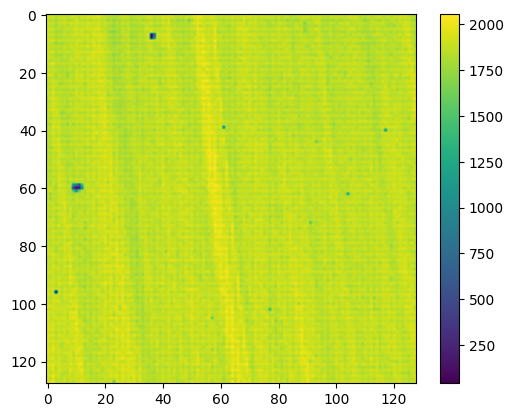

In [110]:
stacked_hband_flats = np.stack([crop(flat) for flat in hband_dict["flats"]])
median_hband_flat = np.median(stacked_hband_flats, axis=0)
plt.imshow(median_hband_flat)
plt.colorbar()

 id xcentroid ycentroid ... flux mag 
--- --------- --------- ... ---- ----
  1 71.379434 3.4890241 ...  inf -inf
  2 88.160147 4.5312896 ...  inf -inf
  3 105.04465 4.5991483 ...  inf -inf
...       ...       ... ...  ...  ...
 50 90.845834 109.05421 ...  inf -inf
 51 10.668109 115.69465 ...  inf -inf
 52  51.85229 120.12478 ...  inf -inf
 53 57.893846 120.03533 ...  inf -inf
Length = 53 rows
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 71.379434 3.4890241    68761.483
  2 88.160147 4.5312896    67243.436
  3 105.04465 4.5991483    68098.469
...       ...       ...          ...
 51 10.668109 115.69465    69884.669
 52  51.85229 120.12478     69215.65
 53 57.893846 120.03533    68290.126
Length = 53 rows


/home/ubuntu/.conda/envs/vipenv/lib/python3.9/site-packages/photutils/detection/daofinder.py:628: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


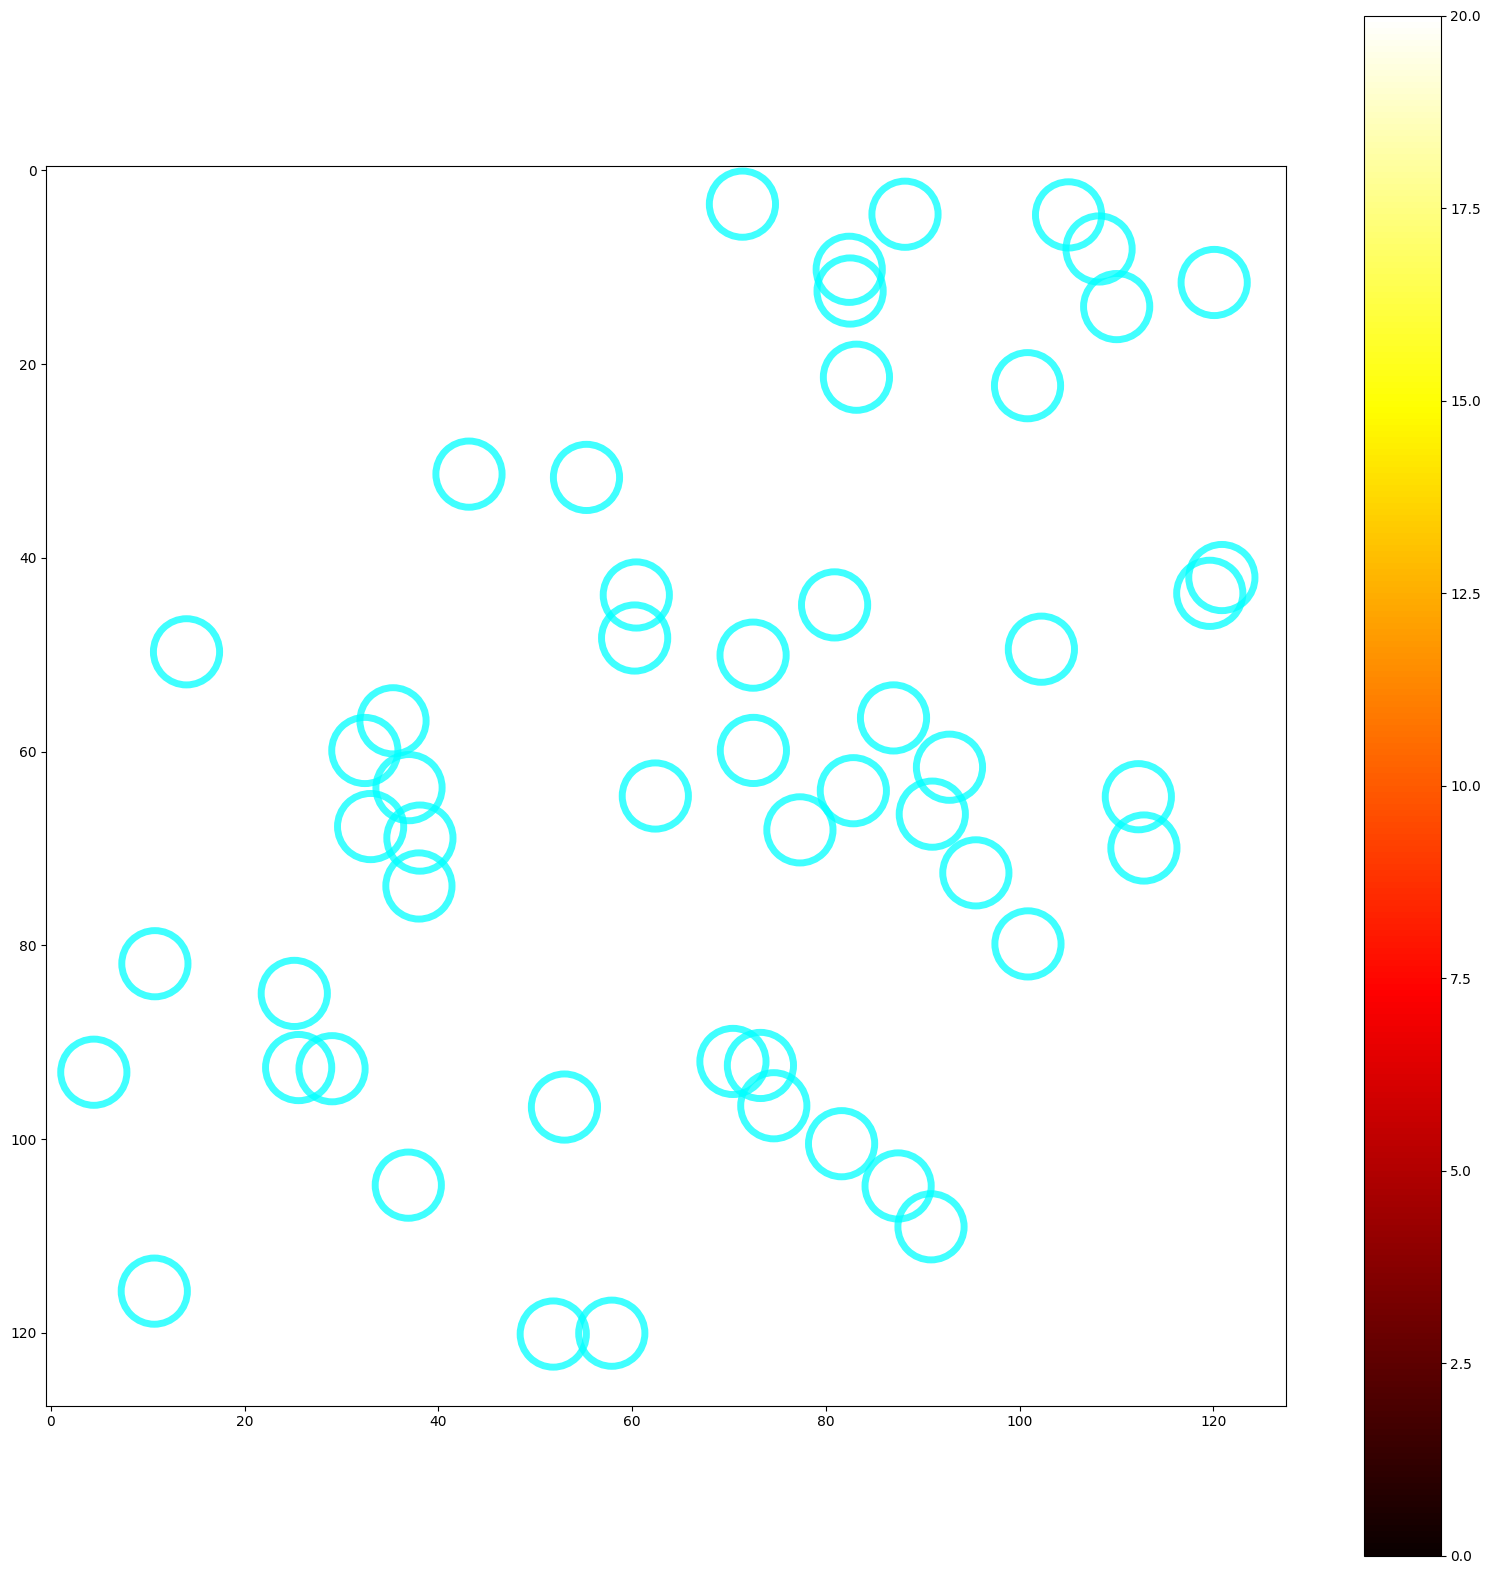

In [106]:
from photutils import DAOStarFinder
from astropy.stats import mad_std
hband_flats = get_flats("Hband")

final_image_cropped = median_hband_flat
bkg_sigma = mad_std(final_image_cropped)
filter_fwhm = 206265*1630.0*1.0e-9/8.2 / 0.012
daofind = DAOStarFinder(fwhm = filter_fwhm, 
                        threshold = 0)#3.0*bkg_sigma)
sources = daofind(final_image_cropped)
for col in sources.colnames:
    sources[col].info.format = '%.8g'
print(sources)

from photutils import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=filter_fwhm)
phot_table = aperture_photometry(final_image_cropped, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

plt.figure(figsize = [20,20])
plt.imshow(final_image_cropped,vmin=0,vmax=20,cmap='hot')
plt.colorbar()
apertures.plot(color = 'cyan', lw = 5, alpha = 0.75)

In [27]:
print(bkg_sigma)
FluxRatio = phot_table[1][3]/phot_table[2][3]
print("Planet Mag = ", -2.5*np.log10(FluxRatio) + 12.388)

1.2349174286296776
Planet Mag =  nan


<ipython-input-27-dc86989db42c>:3: RuntimeWarning: invalid value encountered in log10
  print("Planet Mag = ", -2.5*np.log10(FluxRatio) + 12.388)
